In [11]:
import numpy as truenp

import matplotlib.pyplot as plt
import matplotlib.cm as color
better_magma = color.magma
better_magma.set_bad('black',1.)
import matplotlib.colors as c

from prysm import (
    mathops, 
    conf,
)
from prysm.mathops import (
    np,
    fft,
    interpolate,
    ndimage,
)
from prysm.coordinates import (
    make_xy_grid, 
    cart_to_polar,
)
from prysm.propagation import Wavefront as WF
from prysm.propagation import (
    focus_fixed_sampling,
    focus_fixed_sampling_backprop
)                              
from prysm.thinlens import (
    defocus_to_image_displacement,
    image_displacement_to_defocus,
)
from prysm.geometry import (
    circle,
    spider,
)
from prysm.polynomials import (
    lstsq,
    noll_to_nm,
    zernike_nm,
    zernike_nm_seq,
    hopkins,
    sum_of_2d_modes,
    sum_of_2d_modes_backprop
)
mathops.set_backend_to_cupy()
# conf.config.precision = 32

from astropy.io import (
    fits,
    ascii,
)

from skimage.measure import centroid

from lina.phase_retrieval import ADPR, FDPR, BBPR
from lina.utils import TikhonovInverse

import config_um
import config_um_wcc
from Batoid4LOFT.LAZULI_STOP import Lazuli_stop, readBulkMotion, readDeformation

from psd_utils import PSDUtils

from scipy.optimize import minimize

from scipy.interpolate import RegularGridInterpolator

from tqdm import tqdm

from psd_utils import PSDUtils

from model import off_axis_3m_TMA
from algos import FFPR
import utils

# logging stuff
import logging
psd_log = logging.getLogger('__psd_utils__')
psd_log.disabled = True

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
cfg_um = config_um.load_config_values('unitless')
cfg_um_wcc = config_um_wcc.load_config_values('unitless')

path_um = config_um.get_data_path()
path_um_wcc = config_um_wcc.get_data_path() + '/'

opd_maps = utils.load_pickle('/home/derbyk/src/ffpr/data/opd_maps.pkl')

sys = off_axis_3m_TMA(opd_maps=opd_maps, config_stp=cfg_um, config_wcc=cfg_um_wcc,
                      data_path_stp=path_um, data_path_wcc=path_um_wcc)

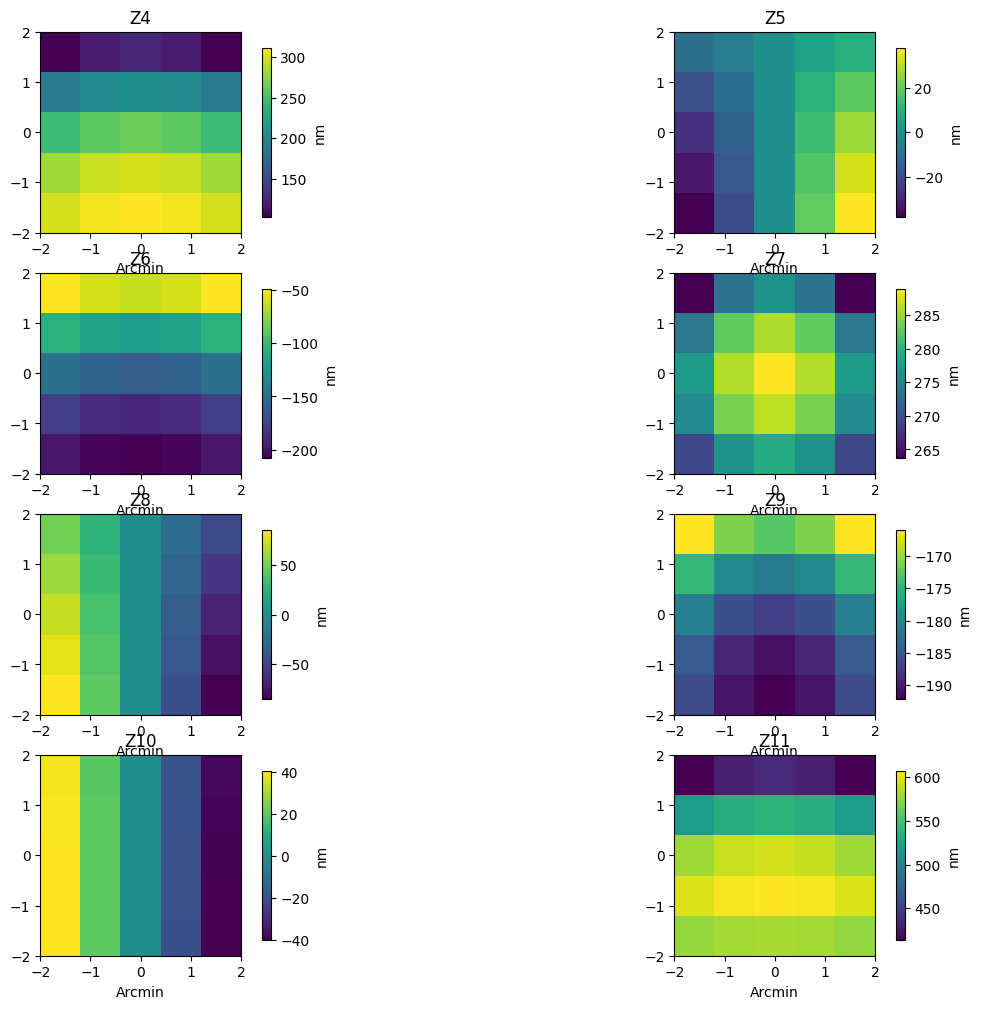

In [13]:
raytrace = Lazuli_stop()

npix = 128
dx = 3000 / npix

# zernike basis (excluding piston) up to Z37
x, y = make_xy_grid(npix, dx=dx)
r, t = cart_to_polar(x, y)
nms = [noll_to_nm(i) for i in range(2, 37)]
zernikes = list(zernike_nm_seq(nms, r, t, norm=True))
zernikes = [z / np.max(np.abs(z)) for z in zernikes]

pupil = circle(1500, r)

# indices for the zernikes which exhibit field dependence that changes with alignment: defocus, coma, astig, trefoil, spherical
# THESE DO NOT CORRESPOND TO NOLL INDICES
inds = [i + 2 for i in range(8)]

# field positions to evaluate
fields_x = np.linspace(-2, 2, 5) / 60 # +/- 16.2 arcmin in x
fields_y = np.linspace(-2, 2, 5) / 60  # +/- 4.8 arcmin in y

# initialize array to hold coeffs for field-dependent zernikes at nominal alignment
field_coeffs_nom = np.zeros((len(inds), len(fields_x), len(fields_y)))

# loop through fields
for i, field_x in enumerate(fields_x):
    for j, field_y in enumerate(fields_y):
        
        # get raytrace OPD at field point
        ray_data = raytrace.get_OPD(fieldX=field_x.get(), fieldY=field_y.get(), npx=npix)
        opd = np.array(ray_data['wavefront'].array.data * ~ray_data['wavefront'].array.mask) * sys.wvl0 * 1e3
        opd[~pupil] = np.nan

        # decompose
        field_coeffs_nom[:, i, j] = lstsq(np.array(zernikes), opd)[inds]

# create interpolators for field-dependent zernikes
field_interps_nom = [interpolate.RegularGridInterpolator((fields_x, fields_y), field_coeffs_nom[i, :, :], method='cubic') for i in range(field_coeffs_nom.shape[0])]

# show field dependence for field-dependent zernikes
plt.figure(figsize=(15, 12))
for i in range(field_coeffs_nom.shape[0]):
    plt.subplot(4, 2, i + 1)
    plt.title(f'Z{i + 4:.0f}')
    plt.imshow(field_coeffs_nom[i, :, :].get().T, extent=[-2, 2, -2, 2])
    plt.xlabel('Arcmin')
    plt.colorbar(fraction=0.016, pad=0.04, label='nm')

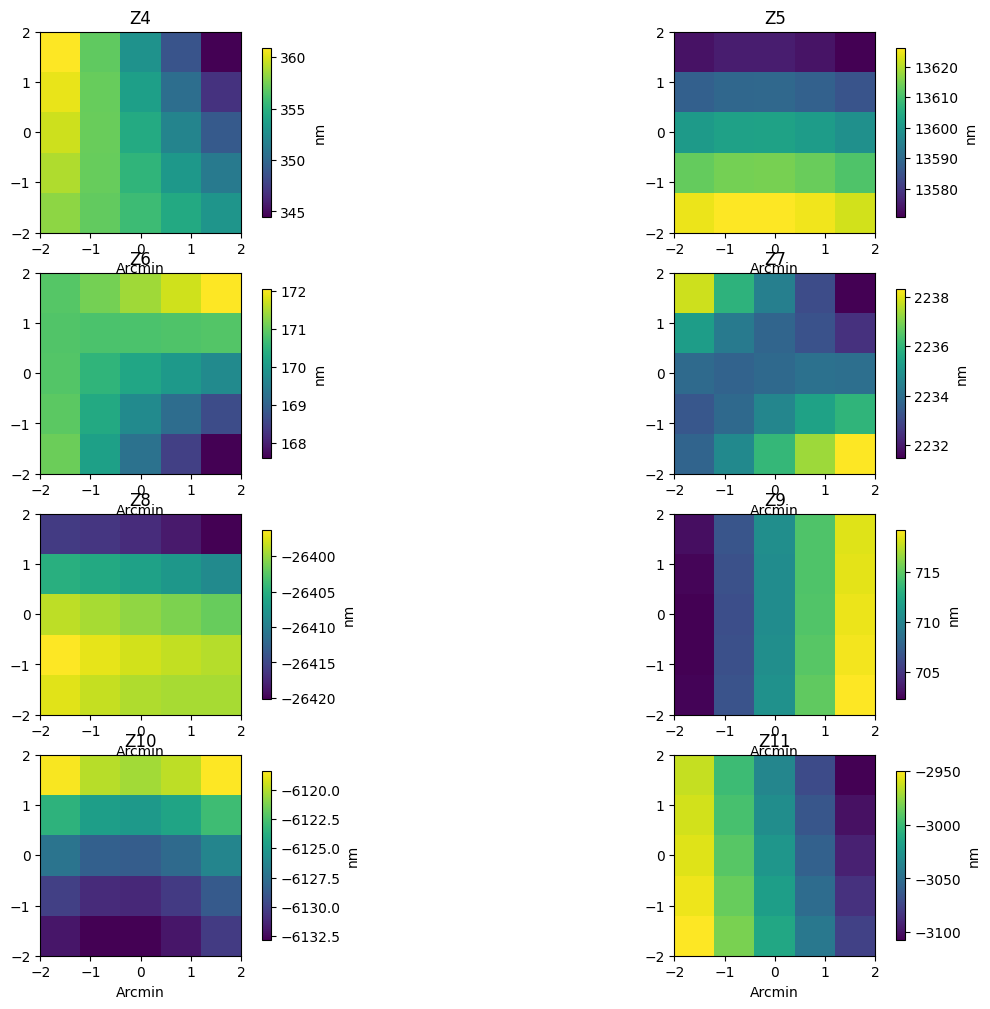

In [14]:
M1_motion = {'user_motion' : {'x' : 1e-3, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}
M2_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}
M3_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}
M4_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}

raytrace = Lazuli_stop(M1_dict=M1_motion, M2_dict=M2_motion, M3_dict=M3_motion, M4_dict=M4_motion, motion_loc=1)

field_coeffs_mis = np.zeros((len(inds), len(fields_x), len(fields_y)))

# loop through fields
for i, field_x in enumerate(fields_x):
    for j, field_y in enumerate(fields_y):
        
        # get raytrace OPD at field point
        ray_data = raytrace.get_OPD(fieldX=field_x.get(), fieldY=field_y.get(), npx=npix)
        opd = np.array(ray_data['wavefront'].array.data * ~ray_data['wavefront'].array.mask) * sys.wvl0 * 1e3
        opd[~pupil] = np.nan

        # decompose
        field_coeffs_mis[:, i, j] = lstsq(np.array(zernikes), opd)[inds]

plt.figure(figsize=(15, 12))
for i in range(field_coeffs_mis.shape[0]):
    plt.subplot(4, 2, i + 1)
    plt.title(f'Z{i + 4:.0f}')
    plt.imshow(field_coeffs_mis[i, :, :].get().T - field_coeffs_nom[i, :, :].get().T, extent=[-2, 2, -2, 2])
    plt.xlabel('Arcmin')
    plt.colorbar(fraction=0.016, pad=0.04, label='nm')

# M2 dx

(array([-60., -40., -20.,   0.,  20.,  40.,  60.]),
 [Text(0, -60.0, '−60'),
  Text(0, -40.0, '−40'),
  Text(0, -20.0, '−20'),
  Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60')])

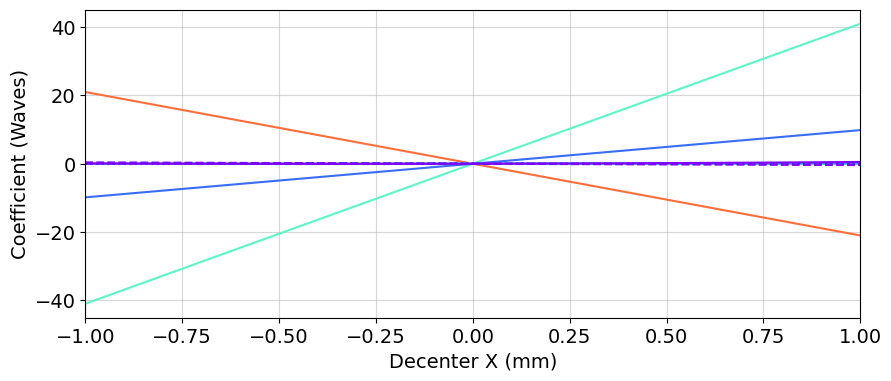

In [15]:
vals = np.linspace(-1e-3, 1e-3, 50)
data = np.zeros((len(vals), len(inds) * 3))

for ind, val in enumerate(vals):

    M1_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}
    M2_motion = {'user_motion' : {'x' : val.get(), 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}
    M3_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}
    M4_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}

    raytrace = Lazuli_stop(M1_dict=M1_motion, M2_dict=M2_motion, M3_dict=M3_motion, M4_dict=M4_motion, motion_loc=1)

    field_coeffs_mis = np.zeros((len(inds), len(fields_x), len(fields_y)))

    # loop through fields
    for i, field_x in enumerate(fields_x):
        for j, field_y in enumerate(fields_y):
            
            # get raytrace OPD at field point
            ray_data = raytrace.get_OPD(fieldX=field_x.get(), fieldY=field_y.get(), npx=npix)
            opd = np.array(ray_data['wavefront'].array.data * ~ray_data['wavefront'].array.mask) * sys.wvl0 * 1e3
            opd[~pupil] = np.nan

            # decompose
            field_coeffs_mis[:, i, j] = lstsq(np.array(zernikes), opd)[inds]

    for i in range(len(inds)):
        data[ind, i * 3] = ((field_coeffs_mis[i, -1, 3] - field_coeffs_nom[i, -1, 3]) - (field_coeffs_mis[i, 0, 3] - field_coeffs_nom[i, 0, 3])) / 4
        data[ind, i * 3 + 1] = ((field_coeffs_mis[i, 3, -1] - field_coeffs_nom[i, 3, -1]) - (field_coeffs_mis[i, 3, 0] - field_coeffs_nom[i, 3, 0])) / 4
        data[ind, i * 3 + 2] = np.mean(field_coeffs_mis[i, :, :] - field_coeffs_nom[i, :, :])

color = iter(plt.cm.rainbow(truenp.linspace(1, 0, 8)))

plt.figure(figsize=(10, 4), dpi=100)
for i in range(len(inds)):
    c = next(color)
    plt.plot(vals.get() * 1e3, data[:, i * 3].get() / 625, label=f'Z{i + 4:.0f}$_A$', c=c, linestyle='dashed')
    plt.plot(vals.get() * 1e3, data[:, i * 3 + 1].get() / 625, label=f'Z{i + 4:.0f}$_B$', c=c, linestyle='dotted')
    plt.plot(vals.get() * 1e3, data[:, i * 3 + 2].get() / 625, label=f'Z{i + 4:.0f}$_C$', c=c)

plt.grid(alpha=0.5)
plt.xlim([-1, 1])
plt.ylabel('Coefficient (Waves)', fontsize=14)
plt.xlabel('Decenter X (mm)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# M2 dy

(array([-150., -100.,  -50.,    0.,   50.,  100.,  150.]),
 [Text(0, -150.0, '−150'),
  Text(0, -100.0, '−100'),
  Text(0, -50.0, '−50'),
  Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150')])

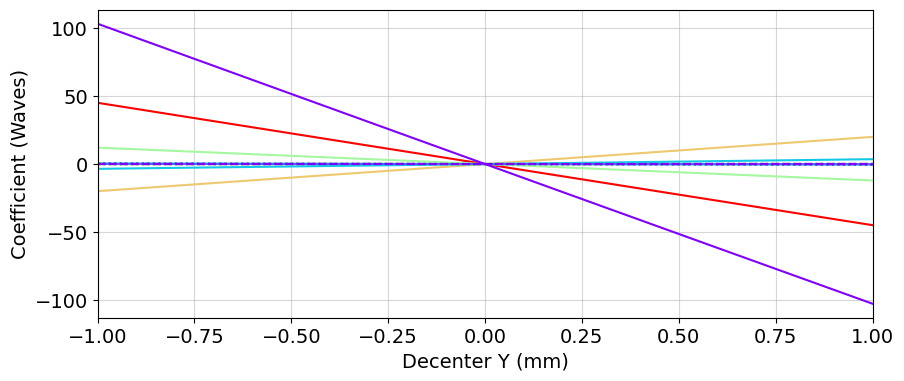

In [16]:
vals = np.linspace(-1e-3, 1e-3, 50)
data = np.zeros((len(vals), len(inds) * 3))

for ind, val in enumerate(vals):

    M1_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}
    M2_motion = {'user_motion' : {'x' : 0, 'y' : val.get(), 'z' : 0, 'tip' : 0, 'tilt' : 0}}
    M3_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}
    M4_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}

    raytrace = Lazuli_stop(M1_dict=M1_motion, M2_dict=M2_motion, M3_dict=M3_motion, M4_dict=M4_motion, motion_loc=1)

    field_coeffs_mis = np.zeros((len(inds), len(fields_x), len(fields_y)))

    # loop through fields
    for i, field_x in enumerate(fields_x):
        for j, field_y in enumerate(fields_y):
            
            # get raytrace OPD at field point
            ray_data = raytrace.get_OPD(fieldX=field_x.get(), fieldY=field_y.get(), npx=npix)
            opd = np.array(ray_data['wavefront'].array.data * ~ray_data['wavefront'].array.mask) * sys.wvl0 * 1e3
            opd[~pupil] = np.nan

            # decompose
            field_coeffs_mis[:, i, j] = lstsq(np.array(zernikes), opd)[inds]

    for i in range(len(inds)):
        data[ind, i * 3] = ((field_coeffs_mis[i, -1, 3] - field_coeffs_nom[i, -1, 3]) - (field_coeffs_mis[i, 0, 3] - field_coeffs_nom[i, 0, 3])) / 4
        data[ind, i * 3 + 1] = ((field_coeffs_mis[i, 3, -1] - field_coeffs_nom[i, 3, -1]) - (field_coeffs_mis[i, 3, 0] - field_coeffs_nom[i, 3, 0])) / 4
        data[ind, i * 3 + 2] = np.mean(field_coeffs_mis[i, :, :] - field_coeffs_nom[i, :, :])

color = iter(plt.cm.rainbow(truenp.linspace(1, 0, 8)))

plt.figure(figsize=(10, 4), dpi=100)
for i in range(len(inds)):
    c = next(color)
    plt.plot(vals.get() * 1e3, data[:, i * 3].get() / 625, label=f'Z{i + 4:.0f}$_A$', c=c, linestyle='dashed')
    plt.plot(vals.get() * 1e3, data[:, i * 3 + 1].get() / 625, label=f'Z{i + 4:.0f}$_B$', c=c, linestyle='dotted')
    plt.plot(vals.get() * 1e3, data[:, i * 3 + 2].get() / 625, label=f'Z{i + 4:.0f}$_C$', c=c)

plt.grid(alpha=0.5)
plt.xlim([-1, 1])
plt.ylabel('Coefficient (Waves)', fontsize=14)
plt.xlabel('Decenter Y (mm)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# M2 dz

(array([-600., -400., -200.,    0.,  200.,  400.,  600.]),
 [Text(0, -600.0, '−600'),
  Text(0, -400.0, '−400'),
  Text(0, -200.0, '−200'),
  Text(0, 0.0, '0'),
  Text(0, 200.0, '200'),
  Text(0, 400.0, '400'),
  Text(0, 600.0, '600')])

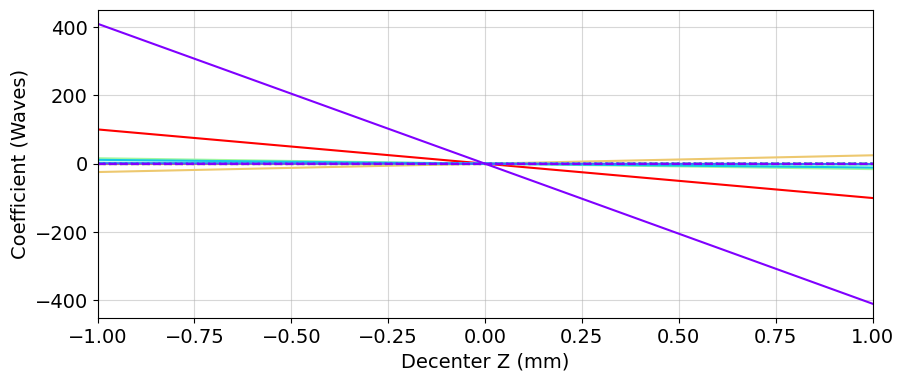

In [17]:
vals = np.linspace(-1e-3, 1e-3, 20)
data = np.zeros((len(vals), len(inds) * 3))

for ind, val in enumerate(vals):

    M1_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}
    M2_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : val.get(), 'tip' : 0, 'tilt' : 0}}
    M3_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}
    M4_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}

    raytrace = Lazuli_stop(M1_dict=M1_motion, M2_dict=M2_motion, M3_dict=M3_motion, M4_dict=M4_motion, motion_loc=1)

    field_coeffs_mis = np.zeros((len(inds), len(fields_x), len(fields_y)))

    # loop through fields
    for i, field_x in enumerate(fields_x):
        for j, field_y in enumerate(fields_y):
            
            # get raytrace OPD at field point
            ray_data = raytrace.get_OPD(fieldX=field_x.get(), fieldY=field_y.get(), npx=npix)
            opd = np.array(ray_data['wavefront'].array.data * ~ray_data['wavefront'].array.mask) * sys.wvl0 * 1e3
            opd[~pupil] = np.nan

            # decompose
            field_coeffs_mis[:, i, j] = lstsq(np.array(zernikes), opd)[inds]

    for i in range(len(inds)):
        data[ind, i * 3] = ((field_coeffs_mis[i, -1, 3] - field_coeffs_nom[i, -1, 3]) - (field_coeffs_mis[i, 0, 3] - field_coeffs_nom[i, 0, 3])) / 4
        data[ind, i * 3 + 1] = ((field_coeffs_mis[i, 3, -1] - field_coeffs_nom[i, 3, -1]) - (field_coeffs_mis[i, 3, 0] - field_coeffs_nom[i, 3, 0])) / 4
        data[ind, i * 3 + 2] = np.mean(field_coeffs_mis[i, :, :] - field_coeffs_nom[i, :, :])

color = iter(plt.cm.rainbow(truenp.linspace(1, 0, 8)))

plt.figure(figsize=(10, 4), dpi=100)
for i in range(len(inds)):
    c = next(color)
    plt.plot(vals.get() * 1e3, data[:, i * 3].get() / 625, label=f'Z{i + 4:.0f}$_A$', c=c, linestyle='dashed')
    plt.plot(vals.get() * 1e3, data[:, i * 3 + 1].get() / 625, label=f'Z{i + 4:.0f}$_B$', c=c, linestyle='dotted')
    plt.plot(vals.get() * 1e3, data[:, i * 3 + 2].get() / 625, label=f'Z{i + 4:.0f}$_C$', c=c)

plt.grid(alpha=0.5)
plt.xlim([-1, 1])
plt.ylabel('Coefficient (Waves)', fontsize=14)
plt.xlabel('Decenter Z (mm)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# M2 tx

(array([-8., -6., -4., -2.,  0.,  2.,  4.,  6.,  8.]),
 [Text(0, -8.0, '−8'),
  Text(0, -6.0, '−6'),
  Text(0, -4.0, '−4'),
  Text(0, -2.0, '−2'),
  Text(0, 0.0, '0'),
  Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8')])

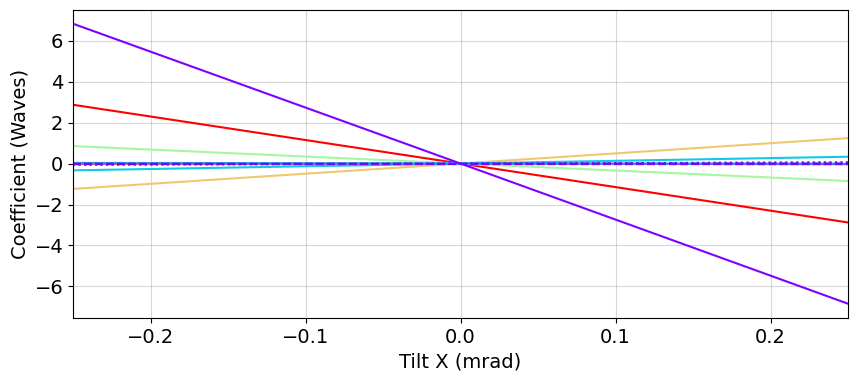

In [18]:
vals = np.linspace(-0.25e-3, 0.25e-3, 10)
data = np.zeros((len(vals), len(inds) * 3))

for ind, val in enumerate(vals):

    M1_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}
    M2_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : val.get(), 'tilt' : 0}}
    M3_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}
    M4_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}

    raytrace = Lazuli_stop(M1_dict=M1_motion, M2_dict=M2_motion, M3_dict=M3_motion, M4_dict=M4_motion, motion_loc=1)

    field_coeffs_mis = np.zeros((len(inds), len(fields_x), len(fields_y)))

    # loop through fields
    for i, field_x in enumerate(fields_x):
        for j, field_y in enumerate(fields_y):
            
            # get raytrace OPD at field point
            ray_data = raytrace.get_OPD(fieldX=field_x.get(), fieldY=field_y.get(), npx=npix)
            opd = np.array(ray_data['wavefront'].array.data * ~ray_data['wavefront'].array.mask) * sys.wvl0 * 1e3
            opd[~pupil] = np.nan

            # decompose
            field_coeffs_mis[:, i, j] = lstsq(np.array(zernikes), opd)[inds]

    for i in range(len(inds)):
        data[ind, i * 3] = ((field_coeffs_mis[i, -1, 3] - field_coeffs_nom[i, -1, 3]) - (field_coeffs_mis[i, 0, 3] - field_coeffs_nom[i, 0, 3])) / 4
        data[ind, i * 3 + 1] = ((field_coeffs_mis[i, 3, -1] - field_coeffs_nom[i, 3, -1]) - (field_coeffs_mis[i, 3, 0] - field_coeffs_nom[i, 3, 0])) / 4
        data[ind, i * 3 + 2] = np.mean(field_coeffs_mis[i, :, :] - field_coeffs_nom[i, :, :])

color = iter(plt.cm.rainbow(truenp.linspace(1, 0, 8)))

plt.figure(figsize=(10, 4), dpi=100)
for i in range(len(inds)):
    c = next(color)
    plt.plot(vals.get() * 1e3, data[:, i * 3].get() / 625, label=f'Z{i + 4:.0f}$_A$', c=c, linestyle='dashed')
    plt.plot(vals.get() * 1e3, data[:, i * 3 + 1].get() / 625, label=f'Z{i + 4:.0f}$_B$', c=c, linestyle='dotted')
    plt.plot(vals.get() * 1e3, data[:, i * 3 + 2].get() / 625, label=f'Z{i + 4:.0f}$_C$', c=c)

plt.grid(alpha=0.5)
plt.xlim([-0.25, 0.25])
plt.ylabel('Coefficient (Waves)', fontsize=14)
plt.xlabel('Tilt X (mrad)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# M2 ty

(array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 [Text(0, -4.0, '−4'),
  Text(0, -3.0, '−3'),
  Text(0, -2.0, '−2'),
  Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4')])

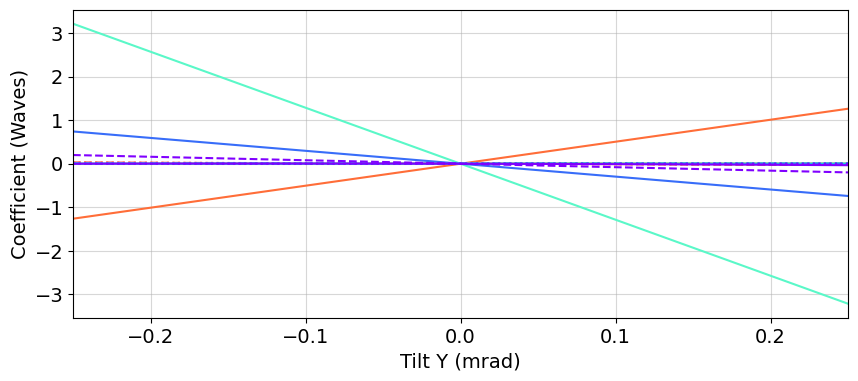

In [19]:
vals = np.linspace(-0.25e-3, 0.25e-3, 10)
data = np.zeros((len(vals), len(inds) * 3))

for ind, val in enumerate(vals):

    M1_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}
    M2_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : val.get()}}
    M3_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}
    M4_motion = {'user_motion' : {'x' : 0, 'y' : 0, 'z' : 0, 'tip' : 0, 'tilt' : 0}}

    raytrace = Lazuli_stop(M1_dict=M1_motion, M2_dict=M2_motion, M3_dict=M3_motion, M4_dict=M4_motion, motion_loc=1)

    field_coeffs_mis = np.zeros((len(inds), len(fields_x), len(fields_y)))

    # loop through fields
    for i, field_x in enumerate(fields_x):
        for j, field_y in enumerate(fields_y):
            
            # get raytrace OPD at field point
            ray_data = raytrace.get_OPD(fieldX=field_x.get(), fieldY=field_y.get(), npx=npix)
            opd = np.array(ray_data['wavefront'].array.data * ~ray_data['wavefront'].array.mask) * sys.wvl0 * 1e3
            opd[~pupil] = np.nan

            # decompose
            field_coeffs_mis[:, i, j] = lstsq(np.array(zernikes), opd)[inds]

    for i in range(len(inds)):
        data[ind, i * 3] = ((field_coeffs_mis[i, -1, 3] - field_coeffs_nom[i, -1, 3]) - (field_coeffs_mis[i, 0, 3] - field_coeffs_nom[i, 0, 3])) / 4
        data[ind, i * 3 + 1] = ((field_coeffs_mis[i, 3, -1] - field_coeffs_nom[i, 3, -1]) - (field_coeffs_mis[i, 3, 0] - field_coeffs_nom[i, 3, 0])) / 4
        data[ind, i * 3 + 2] = np.mean(field_coeffs_mis[i, :, :] - field_coeffs_nom[i, :, :])

color = iter(plt.cm.rainbow(truenp.linspace(1, 0, 8)))

plt.figure(figsize=(10, 4), dpi=100)
for i in range(len(inds)):
    c = next(color)
    plt.plot(vals.get() * 1e3, data[:, i * 3].get() / 625, label=f'Z{i + 4:.0f}$_A$', c=c, linestyle='dashed')
    plt.plot(vals.get() * 1e3, data[:, i * 3 + 1].get() / 625, label=f'Z{i + 4:.0f}$_B$', c=c, linestyle='dotted')
    plt.plot(vals.get() * 1e3, data[:, i * 3 + 2].get() / 625, label=f'Z{i + 4:.0f}$_C$', c=c)

plt.grid(alpha=0.5)
plt.xlim([-0.25, 0.25])
plt.ylabel('Coefficient (Waves)', fontsize=14)
plt.xlabel('Tilt Y (mrad)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# just for legend

(array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 [Text(0, -4.0, '−4'),
  Text(0, -3.0, '−3'),
  Text(0, -2.0, '−2'),
  Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4')])

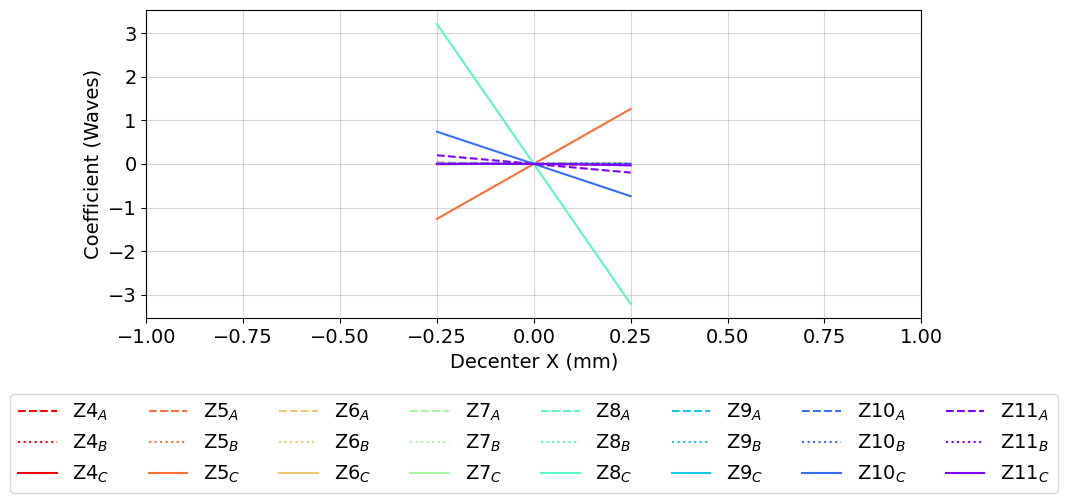

In [20]:
color = iter(plt.cm.rainbow(truenp.linspace(1, 0, 8)))

plt.figure(figsize=(10, 4), dpi=100)
for i in range(len(inds)):
    c = next(color)
    plt.plot(vals.get() * 1e3, data[:, i * 3].get() / 625, label=f'Z{i + 4:.0f}$_A$', c=c, linestyle='dashed')
    plt.plot(vals.get() * 1e3, data[:, i * 3 + 1].get() / 625, label=f'Z{i + 4:.0f}$_B$', c=c, linestyle='dotted')
    plt.plot(vals.get() * 1e3, data[:, i * 3 + 2].get() / 625, label=f'Z{i + 4:.0f}$_C$', c=c)

plt.legend(ncol=8, loc='lower center', bbox_to_anchor=(0.5, -0.6), fontsize=14)
plt.grid(alpha=0.5)
plt.xlim([-1, 1])
plt.ylabel('Coefficient (Waves)', fontsize=14)
plt.xlabel('Decenter X (mm)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)